In [1]:
import pandas as pd
import numpy as np
import plotly as plt
import plotly.express as px
import io
from plotly.subplots import make_subplots
import geopandas as gpd
from shapely.geometry import Point

### Reading in assessment data for every TN Public school for 5 years of historical data
    > Technically 6 but the test was canceled for 2020

In [2]:
# Missing data related to district, school, and enrollment 
data_2017 = pd.read_csv('../data/school_based/2017.csv')
# Missing enrollment data
data_2018 =pd.read_csv('../data/school_based/2018.csv')
data_2019 = pd.read_csv('../data/school_based/2019.csv')
data_2021 = pd.read_csv('../data/school_based/2021.csv')
# Uses different naming conventions than previous years.
# Metric naming will be standardized to align with 2022 conventions
data_2022 = pd.read_csv('../data/school_based/2022.csv')

In [3]:
# List of annual assessment daframes
dfs = [data_2017, data_2018, data_2019, data_2021, data_2022]
df_names = ['year_2017', 'year_2018', 'year_2019', 'year_2021', 'year_2022']

# Initialize a StringIO object to get info in one go
output = io.StringIO()

# Loop through the dfs and their names
for df, name in zip(dfs, df_names):

    # Write the name of the DataFrame to the output
    output.write(f"{name} info:\n")
    
    # Capture the output of the .info() method
    df.info(buf=output)
    
    # Separater
    output.write("\n---\n")

# output 
info_str = output.getvalue()

# Close the StringIO object
output.close()

print(info_str)

year_2017 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440633 entries, 0 to 440632
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   year             440633 non-null  int64  
 1   system           440633 non-null  int64  
 2   school           440633 non-null  int64  
 3   subject          440633 non-null  object 
 4   grade            440633 non-null  object 
 5   subgroup         440633 non-null  object 
 6   valid_tests      440633 non-null  float64
 7   n_below          440633 non-null  object 
 8   n_approaching    440633 non-null  object 
 9   n_on_track       440633 non-null  object 
 10  n_mastered       440633 non-null  object 
 11  pct_below        440633 non-null  object 
 12  pct_approaching  440633 non-null  object 
 13  pct_on_track     440633 non-null  object 
 14  pct_mastered     440633 non-null  object 
 15  pct_on_mastered  440633 non-null  object 
dtypes: float64(1), int64(3

## Issues
- Figure out to deal with suppressed data and salvage as much student demographic data as you can      
  - `*` = The number of **valid** test scores is less than 10.
  - `**` = Any individual proficiency level is <u>less than</u> **1%** or <u>greater than</u> **99%** of the district average.


### Combine Datasets with more or less the same naming conventions

In [4]:
middle_years = pd.concat([data_2018, data_2019, data_2021])

# Renaming columns in middle years to match 2022 naming conventions.  They mean the exact same thing.
middle_years = middle_years.rename(columns={
    'n_on_track': 'n_met_expectations',
    'pct_on_track': 'pct_met_expectations',
    'n_mastered': 'n_exceeded_expectations',
    'pct_mastered': 'pct_exceeded_expectations',
    'subgroup': 'student_group',
    'pct_on_mastered': 'pct_met_exceeded'
})
middle_years.head()

,year,system,system_name,school,school_name,test,subject,grade,student_group,valid_tests,...,n_met_expectations,n_exceeded_expectations,pct_below,pct_approaching,pct_met_expectations,pct_exceeded_expectations,pct_met_exceeded,enrolled,tested,participation_rate
0,2018,10,Anderson County,2,Anderson County High School,EOC,Algebra I,10,All Students,43.0,...,**,**,**,**,**,**,**,NaN,NaN,NaN
1,2018,10,Anderson County,2,Anderson County High School,EOC,Algebra I,10,Economically Disadvantaged,14.0,...,**,**,**,**,**,**,7.1,NaN,NaN,NaN
2,2018,10,Anderson County,2,Anderson County High School,EOC,Algebra I,10,Non-Black/Hispanic/Native American,43.0,...,**,**,**,**,**,**,**,NaN,NaN,NaN
3,2018,10,Anderson County,2,Anderson County High School,EOC,Algebra I,10,Non-Economically Disadvantaged,29.0,...,**,**,**,**,**,**,**,NaN,NaN,NaN
4,2018,10,Anderson County,2,Anderson County High School,EOC,Algebra I,10,Non-English Learners/Transitional 1-4,43.0,...,**,**,**,**,**,**,**,NaN,NaN,NaN


### Combining `middle_years` dataset with 2022 to unify all data except 2017 

In [5]:
# Combine middle years with data_2022 
assessments_unclean = pd.concat([middle_years, data_2022])

# Dropping Enrolled, tested, participation_rate, and n_columns
assessments_unclean = assessments_unclean.drop(['enrolled', 
                                  'tested', 
                                  'participation_rate',
                                  'n_below',
                                  'n_approaching',
                                  'n_met_expectations',
                                  'n_exceeded_expectations'], axis=1)

assessments_unclean.head(n=2)

,year,system,system_name,school,school_name,test,subject,grade,student_group,valid_tests,pct_below,pct_approaching,pct_met_expectations,pct_exceeded_expectations,pct_met_exceeded
0,2018,10,Anderson County,2,Anderson County High School,EOC,Algebra I,10,All Students,43.0,**,**,**,**,**
1,2018,10,Anderson County,2,Anderson County High School,EOC,Algebra I,10,Economically Disadvantaged,14.0,**,**,**,**,7.1


### Fix Missing info in 2017 - I am going to drop this for now and focus on the later years.  There is some mislabeled data and a bit of ambiguity about which test belongs with which subject.  I emailed TDOE, but I'm gonna leave it alone until I hear back.

In [6]:
# Create a unique mapping of system & school for the `assessments_unclean` dataframe.
# This is due to there not being a name associated with the numbers
mapping_assessments = assessments_unclean.drop_duplicates(subset=['system', 'school'])

# Merge the 2017 with the mapping
data_2017 = pd.merge(data_2017, mapping_assessments[['system', 'system_name', 'school', 'school_name']], on=['system', 'school'], how='left')\

# Renaming 2017 with standard naming conventions and dropping unneccissary columns
data_2017 = data_2017.rename(
    columns={
    'pct_on_track': 'pct_met_expectations',
    'pct_mastered': 'pct_exceeded_expectations',
    'subgroup': 'student_group',
    'pct_on_mastered': 'pct_met_exceeded'
})

# Dropping the columns not needed for analysis
data_2017 = data_2017.drop([ 
    'n_below',
    'n_approaching',
    'n_on_track',
    'n_mastered'], axis=1)

data_2017.head(n=1)

,year,system,school,subject,grade,student_group,valid_tests,pct_below,pct_approaching,pct_met_expectations,pct_exceeded_expectations,pct_met_exceeded,system_name,school_name
0,2017,10,2,Algebra I,10,All Students,50.0,**,**,**,**,**,Anderson County,Anderson County High School


In [7]:
data_2017['subject'].unique()

array(['Algebra I', 'Algebra II', 'Biology I', 'Chemistry', 'English II',
       'Geometry', 'English III', 'US History', 'English I', 'ELA',
       'Math', 'Science', 'Integrated Math I', 'Integrated Math II',
       'Integrated Math III'], dtype=object)

looks like school `0` occurs as a missing value frequently.  Ill look at that.
- The schools referenced here do not occur in the known districts past 2017.  I'll drop the nan values and hope it doesn't come back to bite me.

In [8]:
# Create new DF of missing 'system name' values
missing_2017 = data_2017[data_2017['school_name'].isna()]

# Drop all but system and school columns
dropped_missing_2017 = missing_2017[['system', 'school']]

# group by system and unique school
dropped_missing_2017 = missing_2017.groupby('system')['school'].unique()
dropped_missing_2017

system
10            [105]
11              [0]
150             [0]
190      [425, 520]
231            [25]
300             [0]
470            [83]
580         [0, 75]
650             [0]
792    [2075, 2760]
794           [170]
800            [35]
820           [200]
830             [0]
860             [0]
985    [8035, 8080]
Name: school, dtype: object

### Subject/Test Cleaning

Looks like I need to break this table down a bit further to aggregate by test and then subject. The data are noisy and I will filter by the aggregated scores reported in each school. The general hueristic is that the majority of students take these tests in a specific grade.  However, some students take the tests earlier or later than their peers.  In these cases, there can be much grade-level suppression.  Therefore, aggregatons are much less suppressed than grade-level analysis.

In [9]:
# Dropping MSAA & Alt
assessments_unclean = assessments_unclean[assessments_unclean["test"].str.contains("MSAA|MSAA/Alt-Science/Social Studies") == False]

# Filtering for "All Grades" aggregate of each subject
assessments_unclean= assessments_unclean[assessments_unclean["grade"].str.contains("All Grades")]

# Removing student_groups that do not have enough valid tests.
assessments_unclean = assessments_unclean[assessments_unclean['pct_below'] != '*']

# Dropping proficeincy categories to explore solely "met" or "did not meet" expectations
# Dropped 'grade' as it's no longer descriptive
assessments_unclean = assessments_unclean.drop(['grade', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations'], axis=1)

### Import `elsi_clean.csv` as `elsi` and merge with `assessments`.

In [10]:
elsi = pd.read_pickle('../data/school_based/elsi_clean.pkl')  

### Merge of DFs
> I'm really praying that the `system_name` and `school_name` are standardized.  Otherwise, I'll have to reconstruct `system` and `school` from `assessments` to their standardised titles as used in the `elsi` data.

assessments_unclean

In [11]:
# List of comumns
assessments_unclean.columns.tolist()

['year',
 'system',
 'system_name',
 'school',
 'school_name',
 'test',
 'subject',
 'student_group',
 'valid_tests',
 'pct_met_exceeded']

In [12]:
# List of new column order
unclean_order = (['year',
                  'system_name',
                  'school_name',
                  'system',
                  'school',
                  'test',
                  'subject',
                  'student_group',
                  'valid_tests',
                  'pct_met_exceeded'
                ])
# Reorder columns and sort
assessments_unclean = assessments_unclean[unclean_order].sort_values(['year', 'system_name', 'school_name'])

In [13]:
assessments_unclean[assessments_unclean['system']== 670]

,year,system_name,school_name,system,school,test,subject,student_group,valid_tests,pct_met_exceeded
349898,2018,Overton County,A H Roberts Elementary,670,65,TNReady,ELA,All Students,77.0,24.7
349907,2018,Overton County,A H Roberts Elementary,670,65,TNReady,ELA,Non-Black/Hispanic/Native American,75.0,24
349908,2018,Overton County,A H Roberts Elementary,670,65,TNReady,ELA,Non-Economically Disadvantaged,73.0,26
349909,2018,Overton County,A H Roberts Elementary,670,65,TNReady,ELA,Non-English Learners/Transitional 1-4,77.0,24.7
349910,2018,Overton County,A H Roberts Elementary,670,65,TNReady,ELA,Non-Students with Disabilities,67.0,28.4
...,...,...,...,...,...,...,...,...,...,...
394297,2022,Overton County,Wilson Elementary,670,60,TNReady,Social Studies,Non-Economically Disadvantaged,29.0,41.4
394298,2022,Overton County,Wilson Elementary,670,60,TNReady,Social Studies,Non-English Learners/Transitional 1-4,49.0,36.7
394299,2022,Overton County,Wilson Elementary,670,60,TNReady,Social Studies,Non-Students with Disabilities,41.0,43.9
394301,2022,Overton County,Wilson Elementary,670,60,TNReady,Social Studies,Super Subgroup,22.0,27.3


In [14]:
assessments_unclean = assessments_unclean.drop(['system', 'school'], axis=1)
assessments_unclean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381481 entries, 590415 to 658955
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              381481 non-null  int64  
 1   system_name       381481 non-null  object 
 2   school_name       381481 non-null  object 
 3   test              381481 non-null  object 
 4   subject           381481 non-null  object 
 5   student_group     381481 non-null  object 
 6   valid_tests       381481 non-null  float64
 7   pct_met_exceeded  381481 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 26.2+ MB


Hopfully I can merge on the names and not the codes for system and school.  If it doesn't work, I'll have to try to standardize the naming.


In [15]:
# List of elsi columns
elsi.columns.tolist()

['year',
 'system',
 'school',
 'system_name',
 'school_name',
 'school_lvl',
 'tot_enrolled',
 'fte_teachers',
 'stu_tchr_ratio',
 'school_type',
 'magnet',
 'charter',
 'virtual',
 'title_1',
 'lat',
 'long',
 'locale']

specify order of elsi columns

In [16]:
# List of desired elsi column order
elsi_order = ([
 'year',
 'system_name',
 'school_name',
 'system',
 'school',
 'school_lvl',
 'tot_enrolled',
 'fte_teachers',
 'stu_tchr_ratio',
 'school_type',
 'magnet',
 'charter',
 'virtual',
 'title_1',
 'lat',
 'long',
 'locale'
])

# Reorder columns and sort
elsi = elsi[elsi_order].sort_values(['year', 'system_name', 'school_name'])

### Time to join the elsi and assessements 🤞

In [17]:
assessments = pd.merge(assessments_unclean, elsi,
                       how = 'left', 
                       left_on = ['year', 'system_name', 'school_name'],
                       right_on = ['year', 'system_name', 'school_name'])

It appears that **693** rows from the assessment dataset went unmatched when merging.  Past this point I am removing some information that may be useful later.  I'm going to apply geometry now so that will remain in tact when is start .pkl-ing

### 🗺️ Geospatial Stuff

Make assessments GeoSpatial

In [18]:
def geostuff(assessments):
    # Convert 'long' column to numeric
    assessments['long'] = pd.to_numeric(assessments['long'], errors = 'coerce')

    # Convert 'lat column to numeric
    assessments['lat'] = pd.to_numeric(assessments['lat'], errors = 'coerce')

    # Create geometry column
    geometry = [Point(xy) for xy in zip(assessments['long'], assessments['lat'])]

    # Create geodataframe
    gdf = gpd.GeoDataFrame(assessments, geometry=geometry)

    return gdf
assessments = geostuff(assessments)


### 🗺️ .shp Shifting

#### Education Demographic and Geographic Estimates (EDGE) School District Boundaries

In [19]:
# Load EDGE district boundaries for US schools.
EDGE = gpd.read_file('../data/boundaries/EDGE_SCHOOLDISTRICT_TL22_SY2122/EDGE_SCHOOLDISTRICT_TL22_SY2122.shp')

<Axes: >

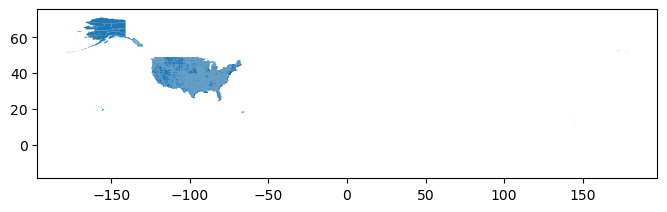

In [20]:
EDGE.plot(figsize=(8,8))

<Axes: >

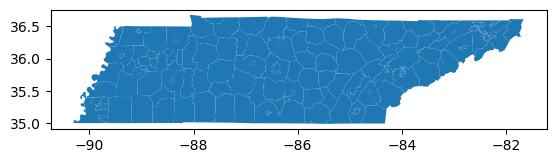

In [21]:
tn_boundaries = EDGE[EDGE['STATEFP'] == '47']
tn_boundaries.plot()

#### The song of my people

In [22]:
# # Function to export Tennessee School Districts as GeoJSON
# def export_tn_leas(input_usa, rockytop_tennessee):
#     # Load All USA District Shapefiles
#     USA = gpd.read_file(input_usa)
    
#     # Filter to Tennessee School Districts
#     rockytop = USA[USA['STATEFP'] == '47']
    
#     # Select desired columns and rename 'NAME' to 'system_name'
#     rockytop = rockytop[['NAME', 'geometry']]
#     rockytop = rockytop.rename(columns={'NAME': 'system_name'})
    
#     # Export as GeoJSON
#     rockytop.to_file(rockytop_tennessee, driver='GeoJSON')
    
#     print("🎶 Good ol' Rocky Top, Rocky Top Tennessee 🎶")

# # Paths to input and output files
# input_usa = '../data/boundaries/EDGE_SCHOOLDISTRICT_TL22_SY2122/EDGE_SCHOOLDISTRICT_TL22_SY2122.shp'
# rockytop_tennessee = '../data/tn_leas.geojson'

# # Export Tennessee School Districts as GeoJSON
# export_tn_leas(input_usa, rockytop_tennessee)

In [23]:
rockytop_tennessee = gpd.read_file('../data/tn_leas.geojson', index_col='system_name')
rockytop_tennessee

,system_name,geometry
0,Hawkins County School District in Rogersville,"MULTIPOLYGON (((-82.99439 36.40104, -82.99434 ..."
1,Monroe County School District in Sweetwater,"POLYGON ((-84.36541 35.64701, -84.36449 35.646..."
2,Arlington Community Schools in Lakeland (9-12),"POLYGON ((-89.71600 35.28793, -89.71620 35.287..."
3,Williamson County School District in Franklin,"POLYGON ((-86.83089 35.97303, -86.83034 35.972..."
4,Wilson County School District in Lebanon,"POLYGON ((-86.39538 36.26263, -86.38800 36.261..."
...,...,...
153,Van Buren County School District,"POLYGON ((-85.26936 35.79339, -85.26941 35.793..."
154,Warren County School District,"POLYGON ((-85.68210 35.83125, -85.68289 35.829..."
155,West Carroll Special District,"POLYGON ((-88.59618 36.11626, -88.59621 36.116..."
156,White County School District,"MULTIPOLYGON (((-85.26863 35.78603, -85.26038 ..."


Looks like there are 17 schools that are managed by the state or do not appear more than once before the year 2022.  These will be removed from the final df.  I will store the names in a list called 'school_removal'.  I'll also keep the fully `**` suppresed schools in my `full_suppression` dataset for that analysis.  Waste not, want not 💾

In [24]:
#looking at NaN values
nan_merge = assessments[assessments.isna().any(axis=1)]

# creating nan_merge and subseting to columns of interest.
nan_merge = nan_merge[['year', 'system_name', 'school_name', 'pct_met_exceeded']]

# replacing full suppression `**` values with 0
nan_merge['pct_met_exceeded'] = nan_merge['pct_met_exceeded'].replace('**', 0)

# filling na values with 0 (don't think this is doing what I want)
nan_merge['pct_met_exceeded'] = nan_merge['pct_met_exceeded'].fillna(0)

# Now that its stripped of strings, I can convert `pct_met_exceeded` to numeric
nan_merge['pct_met_exceeded'] = nan_merge['pct_met_exceeded'].apply(pd.to_numeric)

# Create a pivot table to explore nan values from merge
nan_pivot = pd.pivot_table(nan_merge, 
                       values = 'pct_met_exceeded',
                       index = ['system_name', 'school_name'],
                       columns = 'year',
                       aggfunc = np.mean)
nan_pivot

year                                                                                                   2018  \
system_name                                        school_name                                                
Department of Children's Services                  DCS Affiliated Schools                               0.0   
                                                   Gateway to Independence                              0.0   
                                                   Wilder Youth Development Center                      0.0   
Department of Children's Services Education Div... DCS Affiliated Schools                               NaN   
                                                   Wilder Youth Development Center                      NaN   
Hamilton County                                    Dupont Elementary                                    NaN   
                                                   Ivy Academy, Inc.                                    NaN   
Rhea County Department of Education                Frazier Elementary                                   NaN   
                                                   Graysville Elementary School                         NaN   
                                                   Rhea Central Elementary                              NaN   
                                                   Rhea County High School                              NaN   
                                                   Rhea Middle School                                   NaN   
                                                   Spring City Elementary                               NaN   
                                                   Spring City Middle School                            NaN   
Shelby County                                      Southern Avenue Charter School Of Academic Exce...   NaN   
Tennessee Schools for the Deaf                     Tennessee School For Deaf Elementary School          NaN   
                                                   Tennessee School for the Deaf Upper School           NaN   

year                                                                                                        2019  \
system_name                                        school_name                                                     
Department of Children's Services                  DCS Affiliated Schools                                    NaN   
                                                   Gateway to Independence                                   NaN   
                                                   Wilder Youth Development Center                           NaN   
Department of Children's Services Education Div... DCS Affiliated Schools                               2.727273   
                                                   Wilder Youth Development Center                      0.000000   
Hamilton County                                    Dupont Elementary                                   22.828125   
                                                   Ivy Academy, Inc.                                   30.362105   
Rhea County Department of Education                Frazier Elementary                                        NaN   
                                                   Graysville Elementary School                              NaN   
                                                   Rhea Central Elementary                                   NaN   
                                                   Rhea County High School                                   NaN   
                                                   Rhea Middle School                                        NaN   
                                                   Spring City Elementary                                    NaN   
                                                   Spring City Middle School                                 NaN   
Shelby County                     

### Exploring Fully Suppressed outliers (The Great Merging is accommplished)
>  ``**`` suppresion is applied to the school level subject scores if that school performes above 95% or below 5% of a district's average.  


> Subject matter expert confirmed that it is the majority case that schools scores are suppressed for falling under 5% of the district average.  There are only a 'handful' of scores suppressed for averages greater than 95% of the district.

In [25]:
# Find all fully supressed proficiency scores
full_suppression = assessments.loc[(assessments['pct_met_exceeded'] == '**')]

# Drop some columns that will be unneccisary for analysis
full_suppression.drop(['system','school','pct_met_exceeded'], axis=1)
full_suppression.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 44454 entries, 9 to 381478
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   year              44454 non-null  int64   
 1   system_name       44454 non-null  object  
 2   school_name       44454 non-null  object  
 3   test              44454 non-null  object  
 4   subject           44454 non-null  object  
 5   student_group     44454 non-null  object  
 6   valid_tests       44454 non-null  float64 
 7   pct_met_exceeded  44454 non-null  object  
 8   system            44282 non-null  object  
 9   school            44282 non-null  object  
 10  school_lvl        44282 non-null  object  
 11  tot_enrolled      44282 non-null  object  
 12  fte_teachers      44282 non-null  object  
 13  stu_tchr_ratio    44282 non-null  object  
 14  school_type       44282 non-null  object  
 15  magnet            44282 non-null  object  
 16  charter           

### Exporting full_suppression file as full_suppression.pkl 🥒 to the school_based subdirectory in my data folder.

In [26]:
## CAUTION!: Don't turn on the pkl generator unless hungry.
#full_suppression.to_pickle('../data/school_based/full_suppression.pkl')  

### Pruning data ✂

In [27]:
# Generate list to remove schools identified in the nan_merge
school_removal = np.unique(nan_merge['school_name'].values).tolist()

# Remove previously identified schools from assessments dataframe.
assessments = assessments[~assessments['school_name'].isin(school_removal)]

In [28]:
# Removing fully suppressed scores
assessments = assessments[assessments.pct_met_exceeded != '**']

# converting pct_met_exceeded to numeric
assessments['pct_met_exceeded'] = pd.to_numeric(assessments['pct_met_exceeded'])
assessments.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 335452 entries, 0 to 381480
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   year              335452 non-null  int64   
 1   system_name       335452 non-null  object  
 2   school_name       335452 non-null  object  
 3   test              335452 non-null  object  
 4   subject           335452 non-null  object  
 5   student_group     335452 non-null  object  
 6   valid_tests       335452 non-null  float64 
 7   pct_met_exceeded  335452 non-null  float64 
 8   system            335452 non-null  object  
 9   school            335452 non-null  object  
 10  school_lvl        335452 non-null  object  
 11  tot_enrolled      335452 non-null  object  
 12  fte_teachers      335452 non-null  object  
 13  stu_tchr_ratio    335452 non-null  object  
 14  school_type       335452 non-null  object  
 15  magnet            335452 non-null  object  
 16 

### Fixing dtypes, adding weights, and encoding yes/no columns.

In [29]:
# Convert pct_met_exceeded to percentage
assessments['pct_met_exceeded'] = assessments['pct_met_exceeded'] / 100

# Convert columns to numeric
columns_to_convert = ['fte_teachers', 'stu_tchr_ratio']
assessments[columns_to_convert] = assessments[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert 'Yes' to 1 and 'No' to 0
assessments['magnet'] = assessments['magnet'].replace({'1-Yes': 1, '2-No': 0})
assessments['charter'] = assessments['charter'].replace({'1-Yes': 1, '2-No': 0})
assessments['title_1'] = assessments['title_1'].replace({'1-Yes': 1, '2-No': 0})

# Create three weighted columns for 'pct_met_exceeded', 'stu_tchr_ratio', 'fte_teachers'
columns_to_weight = ['pct_met_exceeded', 'stu_tchr_ratio', 'fte_teachers']
weight = 'valid_tests'

# Apply the weight and store in _w columns
assessments[['pct_met_exceeded_w', 'stu_tchr_ratio_w', 'fte_teachers_w']] = assessments[columns_to_weight].multiply(
    assessments[weight], axis=0)


### Exploring the assessments.  
Looks like for the EOC and TNready assessments, there were **no valid science scores** for the year 2019.  This is further complicated by the fact that `Chemistry` and `English III` subjects only appear in 2018.  Maybe it would be fair to assiciate all subjects with a content area.  

In [30]:
# Look at the subjects for each test.    
test_subjects = assessments[['year','test', 'subject', 'student_group', 'valid_tests', 'pct_met_exceeded']]

# Focus on all_students to ignore subpopulation calculations
test_subjects = test_subjects.loc[(test_subjects['student_group'] == 'All Students')]

# Create pivot table to view pct_met_exceeded proficiency for valid tests for the count of valid tests per year
test_subjects_pivot = pd.pivot_table(test_subjects,
                       values = 'pct_met_exceeded',
                       index = ['test', 'subject'],
                       columns = 'year',
                       aggfunc = np.mean)


In [31]:
# Pivot table of unweighted proficiency scores by test and subject
test_subjects_pivot

year                             2018      2019      2021      2022
test    subject                                                    
EOC     Algebra I            0.357769  0.364470  0.332683  0.329588
        Algebra II           0.271308  0.273917  0.209300  0.255107
        Biology I            0.464125       NaN  0.379231  0.384062
        Chemistry            0.373266       NaN       NaN       NaN
        English I            0.254311  0.310310  0.289449  0.331628
        English II           0.338779  0.399749  0.348632  0.418116
        English III          0.287808       NaN       NaN       NaN
        Geometry             0.277191  0.330092  0.255570  0.268640
        Integrated Math I    0.374805  0.366200  0.343032  0.345419
        Integrated Math II   0.302521  0.322358  0.253860  0.306440
        Integrated Math III  0.192909  0.258178  0.183525  0.213714
        US History           0.284515  0.293695  0.330708  0.348105
TNReady ELA                  0.326268  0.322544  0.288017  0.337688
        Math                 0.357148  0.398396  0.310407  0.338372
        Science              0.550480       NaN  0.366250  0.378715
        Social Studies       0.362279  0.366542  0.348096  0.387894

### Subject Content Mapping
> I'd like to be able to see aggregate scores for each content area, not just each individual assessment.  This way I can aggregate average content proficiency by school level (e.g. middle school vs. high school).

In [32]:
# Get a list of unique subjects for an additional labeling column
subjects_list = np.unique(assessments['subject'].values).tolist()

# Lets take a look at all of the subjects so that we can associate
# them with their content area.
subjects_list

['Algebra I',
 'Algebra II',
 'Biology I',
 'Chemistry',
 'ELA',
 'English I',
 'English II',
 'English III',
 'Geometry',
 'Integrated Math I',
 'Integrated Math II',
 'Integrated Math III',
 'Math',
 'Science',
 'Social Studies',
 'US History']

In [33]:
# Creating a dictionary of subjects and their associated content
subject_content = {
    'Algebra I': 'Math',
    'Algebra II': 'Math',
    'Biology I': 'Science',
    'Chemistry': 'Science',
    'ELA': 'ELA',
    'English I': 'ELA',
    'English II': 'ELA',
    'English III': 'ELA',
    'Geometry': 'Math',
    'Integrated Math I': 'Math',
    'Integrated Math II': 'Math',
    'Integrated Math III': 'Math',
    'Math': 'Math',
    'Science': 'Science',
    'Social Studies': 'Social Studies',
    'US History': 'Social Studies'
}

In [34]:
# Create new column with maping funciton using subject_content dictionary
assessments['subject_area'] = assessments['subject'].map(subject_content)

# place 'subject_area' column beside the 'subject' column
cols = assessments.columns.tolist()
cols.insert(cols.index('subject') +1, cols.pop(cols.index('subject_area')))
assessments = assessments[cols]

### 🥒 Exporting assessments dataframe as assessments_clean.pkl to the school_based subdirectory in my data folder.

In [35]:
## CAUTION!: Don't turn on the pkl generator unless hungry.
#assessments.to_pickle('../data/school_based/assessments_clean.pkl')  